In [1]:
# !wget https://huggingface.co/datasets/mesolitica/malaysian-youtube-audio-instructions/resolve/main/filter-pseudolabel.jsonl

In [2]:
!head -n 1 filter-pseudolabel.jsonl

["output-audio/1-0-0.mp3", "anda tahu keuntungan boleh lebih tinggi daripada keuntungan kewangan rumah maka saya tidak akan mencari dalam akaun saya akan mencari ke dalam ethereum atau beberapa crypto punks bergantung pada faktor risiko anda kerana rumah kajang dihantar tidak mengganggu dsr saya sejauh ini jadi sekarang apa posisi saya untuk mendapatkan kewangan ketiga jadi mungkin setelah melihat sekeliling saya menemui seorang penjual yang dapat menutupi perhubungan tetapi bank hanya menerima 70% dari itu saya boleh membayar perbezaan dengan menggunakan wang ini kerana sekali lagi ia menyusahkan saya dan aset tetapi jika anda tidak selesa dengan mencari"]


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
from transformers.models.bart.modeling_bart import shift_tokens_right
from transformers.models.gpt2 import modeling_gpt2
import malaya
from malaya.text.normalization import cardinal
import malaya_speech
from malaya_speech.utils.subword import merge_sentencepiece_tokens
import re
import itertools
import unicodedata
import json
import numpy as np

tokenizer = malaya.tokenizer.Tokenizer(hypen = False, parliament = False, time = False, time_pukul = False,
                                      temperature = False, distance = False, volume = False, duration = False,
                                      weight = False, date = False, money = False)

Cannot import beam_search_ops from Tensorflow 1, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] for stemmer will not available to use, make sure Tensorflow 1 version >= 1.15
`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [5]:
def tokenize_and_replace(t):
    tokenized = tokenizer.tokenize(t)
    for i in range(len(tokenized)):
        c = cardinal(tokenized[i])
        if c != tokenized[i]:
            tokenized[i] = c
    return ' '.join(tokenized)

tokenize_and_replace('pada 15 ogos 1940 pihak berikat menyerang perancis selatan serangan ini dipanggil operation dragoon')

'pada lima belas ogos seribu sembilan ratus empat puluh pihak berikat menyerang perancis selatan serangan ini dipanggil operation dragoon'

In [6]:
vocabs = [" ", "a", "e", "n", "i", "t", "o", "u", "s", "k", "r", "l", "h", "d", "m", "g", "y", "b", "p", "w", "c", "f", "j", "v", "z", "0", "1", "x", "2", "q", "5", "3", "4", "6", "9", "8", "7"]
sr = 16000

def preprocessing_text(string):
    
    string = tokenize_and_replace(string)
    string = unicodedata.normalize('NFC', string.lower())
    string = ''.join([c if c in vocabs else ' ' for c in string])
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = (
        ''.join(''.join(s)[:2] for _, s in itertools.groupby(string))
    )
    return string

In [7]:
filtered = []

with open('filter-pseudolabel.jsonl') as fopen:
    for l in fopen:
        l = json.loads(l)
        filtered.append(l)
        
len(filtered)

514126

In [8]:
filtered[-1]

['output-audio/3-10682-51.mp3',
 'Dia kalau cuak lain Cuak dia tak bercakap Satu lagi Orang yang ugut dia tu pun Tak nampak mengugut Kau tahu kan benda ni Aku nak buat benda ni Itu tak nampak garang tu So dia tak akan cuaknya Kalau dia tahu yang Mika ni macam mana So macam itulah Tapi for now Mereka banyak spill back Apa yang terjadi Daripada site Mika Daripada site Ceman Mereka ada buat live And ceritakan overall Apa yang jadi malam tersebut Mika pun sekarang Dia asyik-asyik Dia Dia Dia spill lagi']

In [9]:
model = malaya_speech.force_alignment.transducer.huggingface(model = 'mesolitica/conformer-medium-mixed')

In [10]:
_ = model.cuda()

In [11]:
y, _ = malaya_speech.load(filtered[-1][0].replace('output-audio/', 'filter-audio/'))
results = model.predict(y, preprocessing_text(filtered[-1][1]))

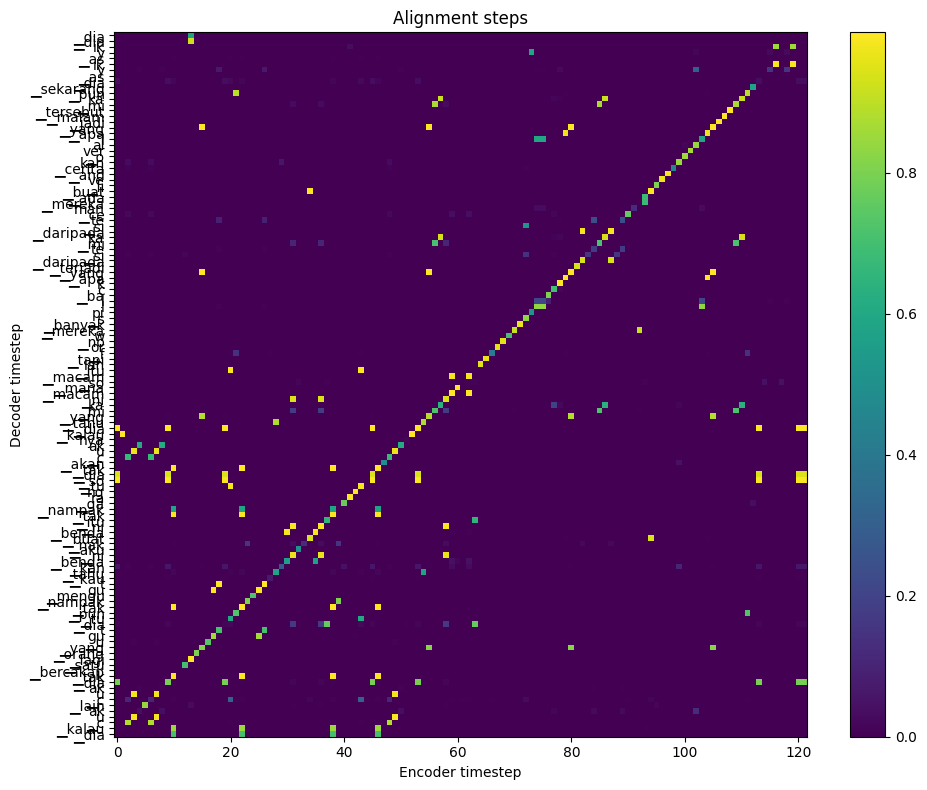

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    results['alignment'],
    aspect='auto',
    origin='lower',
    interpolation='none')
ax.set_yticks(range(len(results['subwords'])))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(results['subwords'])
fig.colorbar(im, ax=ax)
xlabel = 'Encoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Decoder timestep')
plt.tight_layout()
plt.show()

In [13]:
results.keys()

dict_keys(['words_alignment', 'subwords_alignment', 'subwords', 'alignment'])

In [28]:
diag = np.diag(results['alignment'])
diag.shape

(122,)

In [29]:
len(results['subwords_alignment'])

122

In [30]:
split, temp = [], []
for no, r in enumerate(results['subwords_alignment']):
    if r['score'] >= 0.05 or diag[no] > 0.1:
        temp.append(r)
    
    else:
        if len(temp):
            split.append(temp)
            temp = []
            
if len(temp):
    split.append(temp)
    
selected = []
for s in split:
    start = s[0]['start']
    end = s[-1]['end'] + 0.1
    if end - start >= 0.5:
        seq = [s_['text'] for s_ in s]
        merged = model.tokenizer.sp_model.Decode(model.tokenizer.sp_model.PieceToId(seq))
        selected.append((merged, start, end))

In [31]:
len(selected)

7

In [32]:
selected[0]

('satu lagi orang yang ugut', 4.64, 5.779999999999999)

In [33]:
import IPython.display as ipd

ipd.Audio(y[int(selected[0][1] * sr): int(selected[0][2] * sr)], rate = sr)